In [243]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(color_codes=True)

In [244]:
file_path = 'sensor_data.csv'
sen_data = pd.read_csv(file_path)
print(sen_data.dtypes)
sen_data.head()

datetime      object
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object


,datetime,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880


In [245]:
print("-----BEFORE-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

# Date convert to timestamp data type
sen_data['datetime'] = pd.to_datetime(sen_data['datetime'])

print("-----AFTER-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

-----BEFORE-----
2015-01-01 06:00:00
<class 'str'>
-----AFTER-----
2015-01-01 06:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [246]:
fail_dt = pd.read_csv('fail_log.csv')
fail_dt.head()

,datetime
0,2/4/2015 6:00
1,3/21/2015 6:00
2,4/5/2015 6:00
3,5/5/2015 6:00
4,5/20/2015 6:00


In [247]:
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime']) # Date convert to timestamp data type

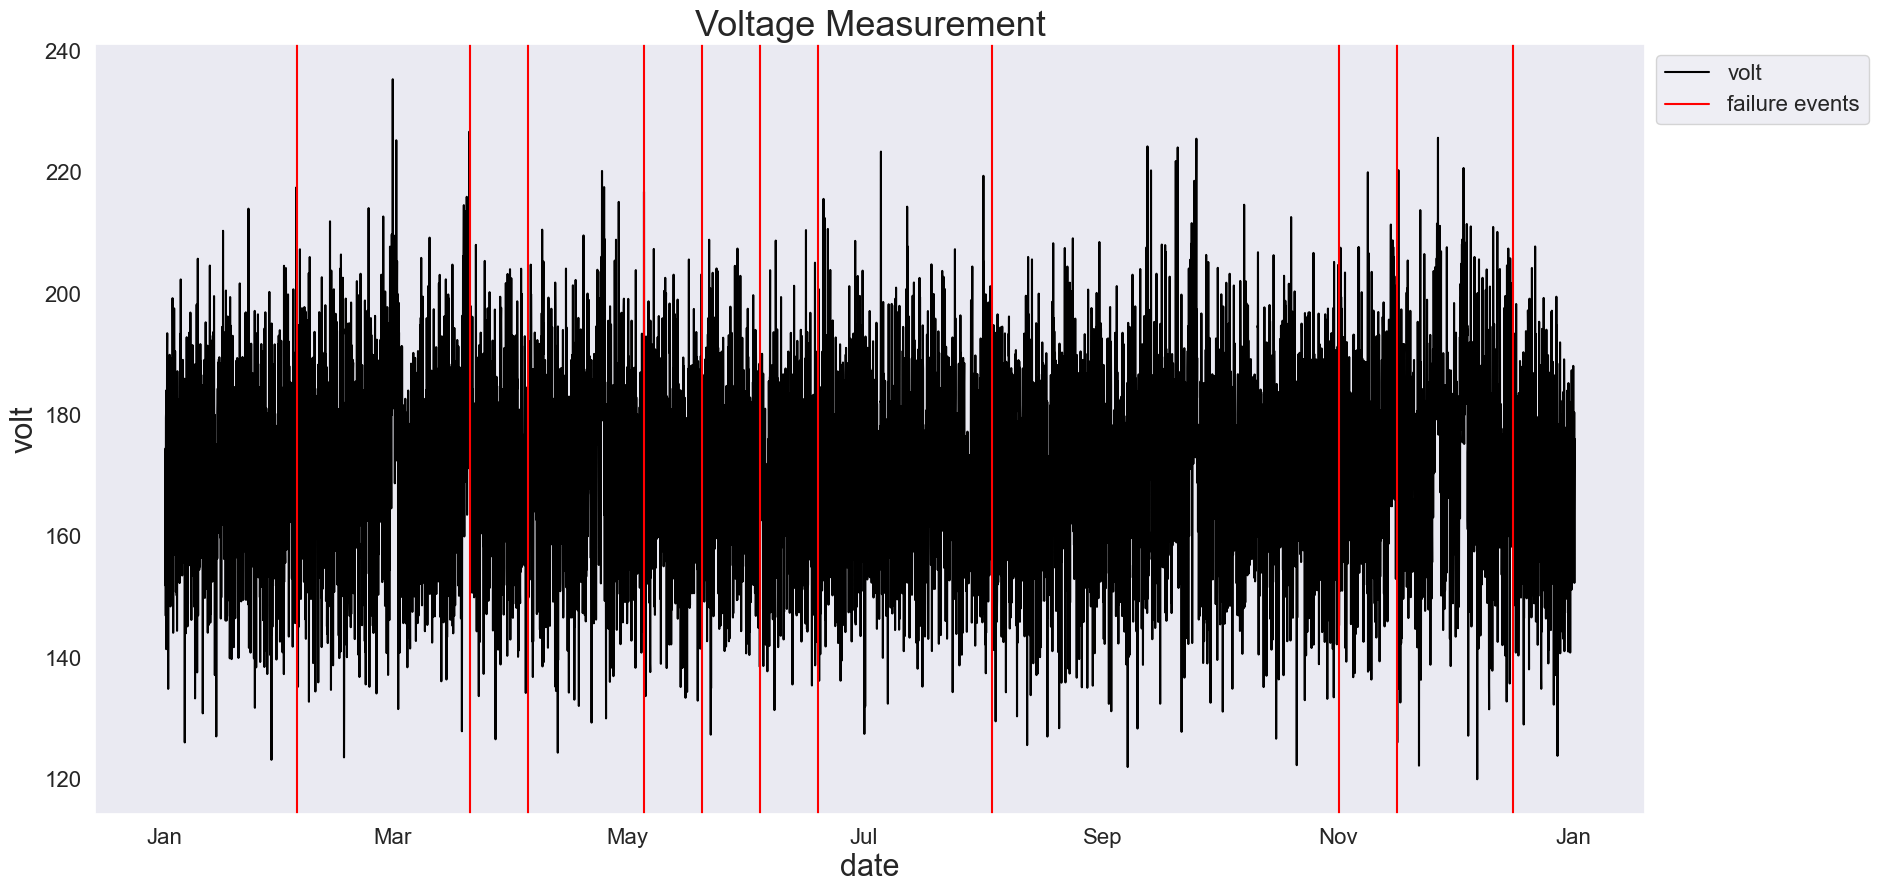

In [248]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(sen_data['datetime'], sen_data['volt'], color='black', label='volt')
ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
for dt in fail_dt['datetime'][1:]:
  ax.axvline(x=dt, color='red')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

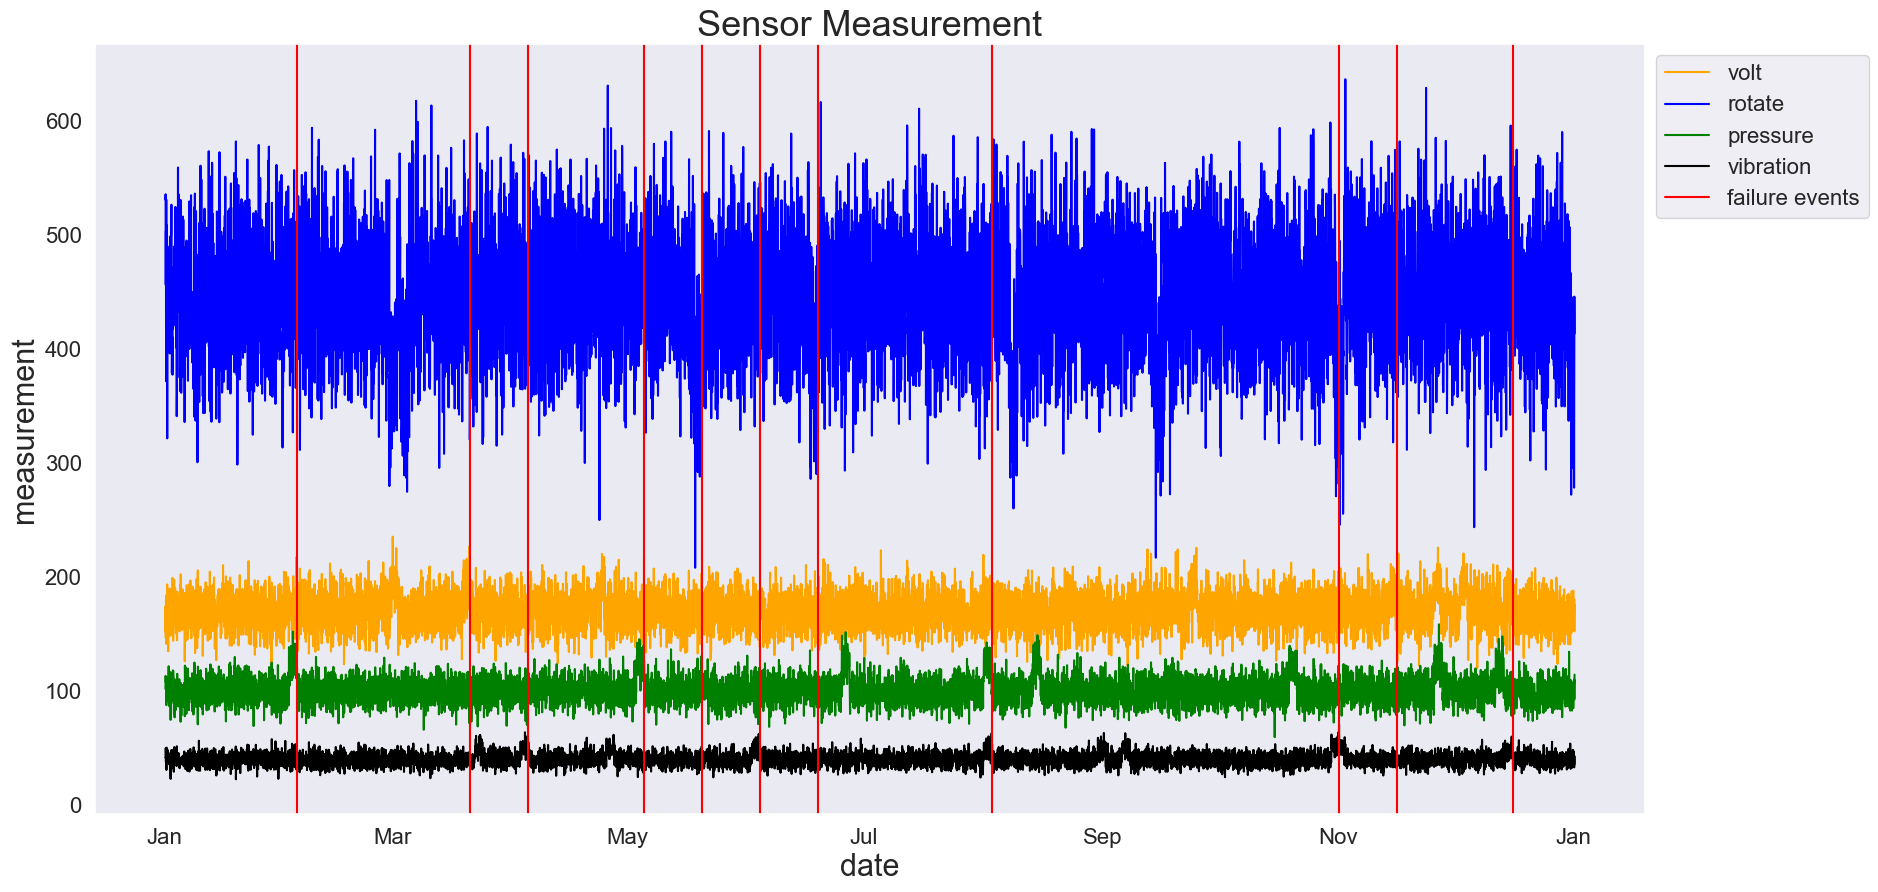

In [249]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None):
        if predicted_fail_dt.empty != True:
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

plot_diagnostic_data(sen_data, fail_dt, None)

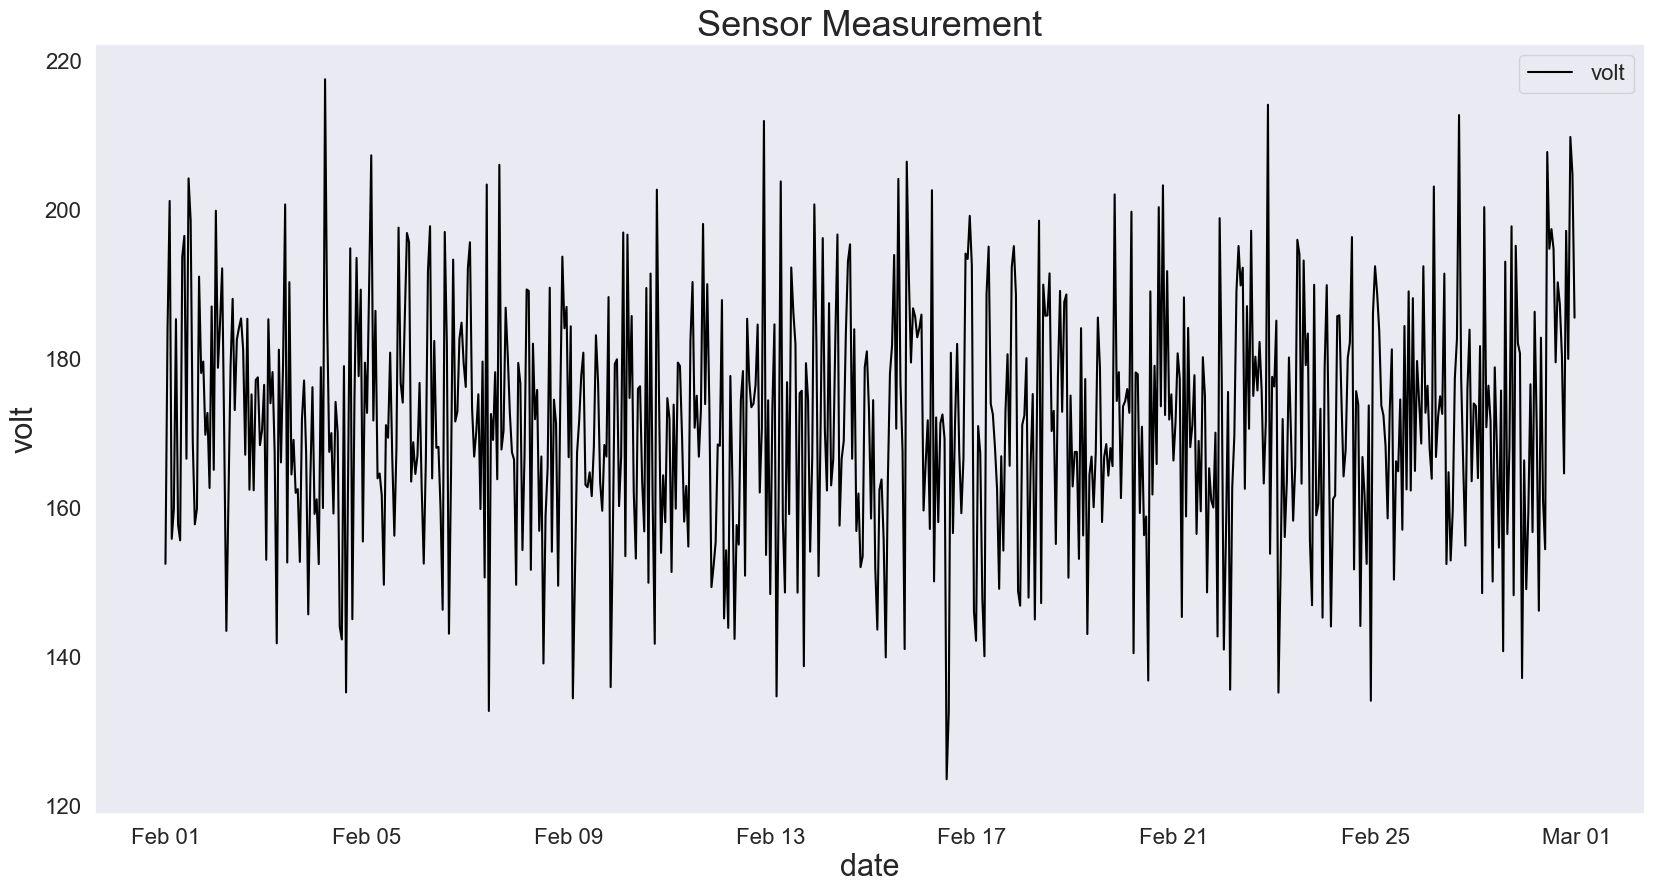

In [250]:
# Extract February data
data = sen_data[[True if data.strftime("%B") == 'February' else False for data in sen_data['datetime']]]
data = data.reset_index(drop=True)

fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)

plt.title("Sensor Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

In [251]:
win_size = 20
data = data.sort_values(by='datetime', ascending = True) # Ensure time order is preserved
data['roll_volt'] = np.nan
for i in range(len(data)-20+1):
    data.at[i+win_size-1, 'roll_volt'] = data['volt'][i:i+win_size].mean()

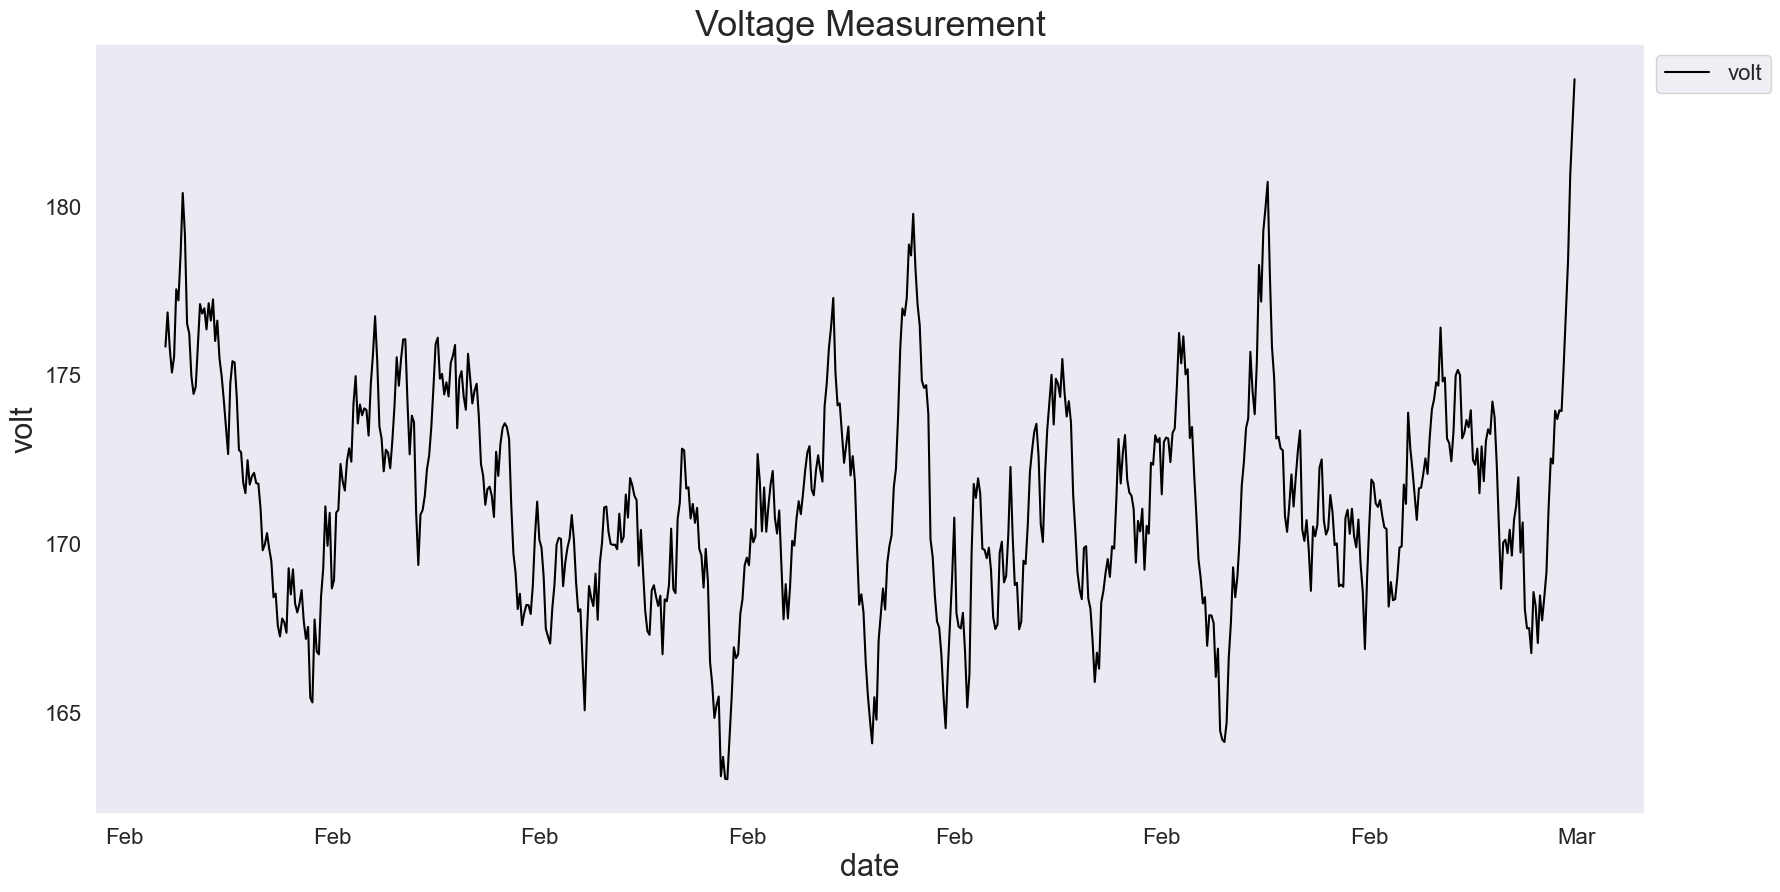

In [252]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['roll_volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

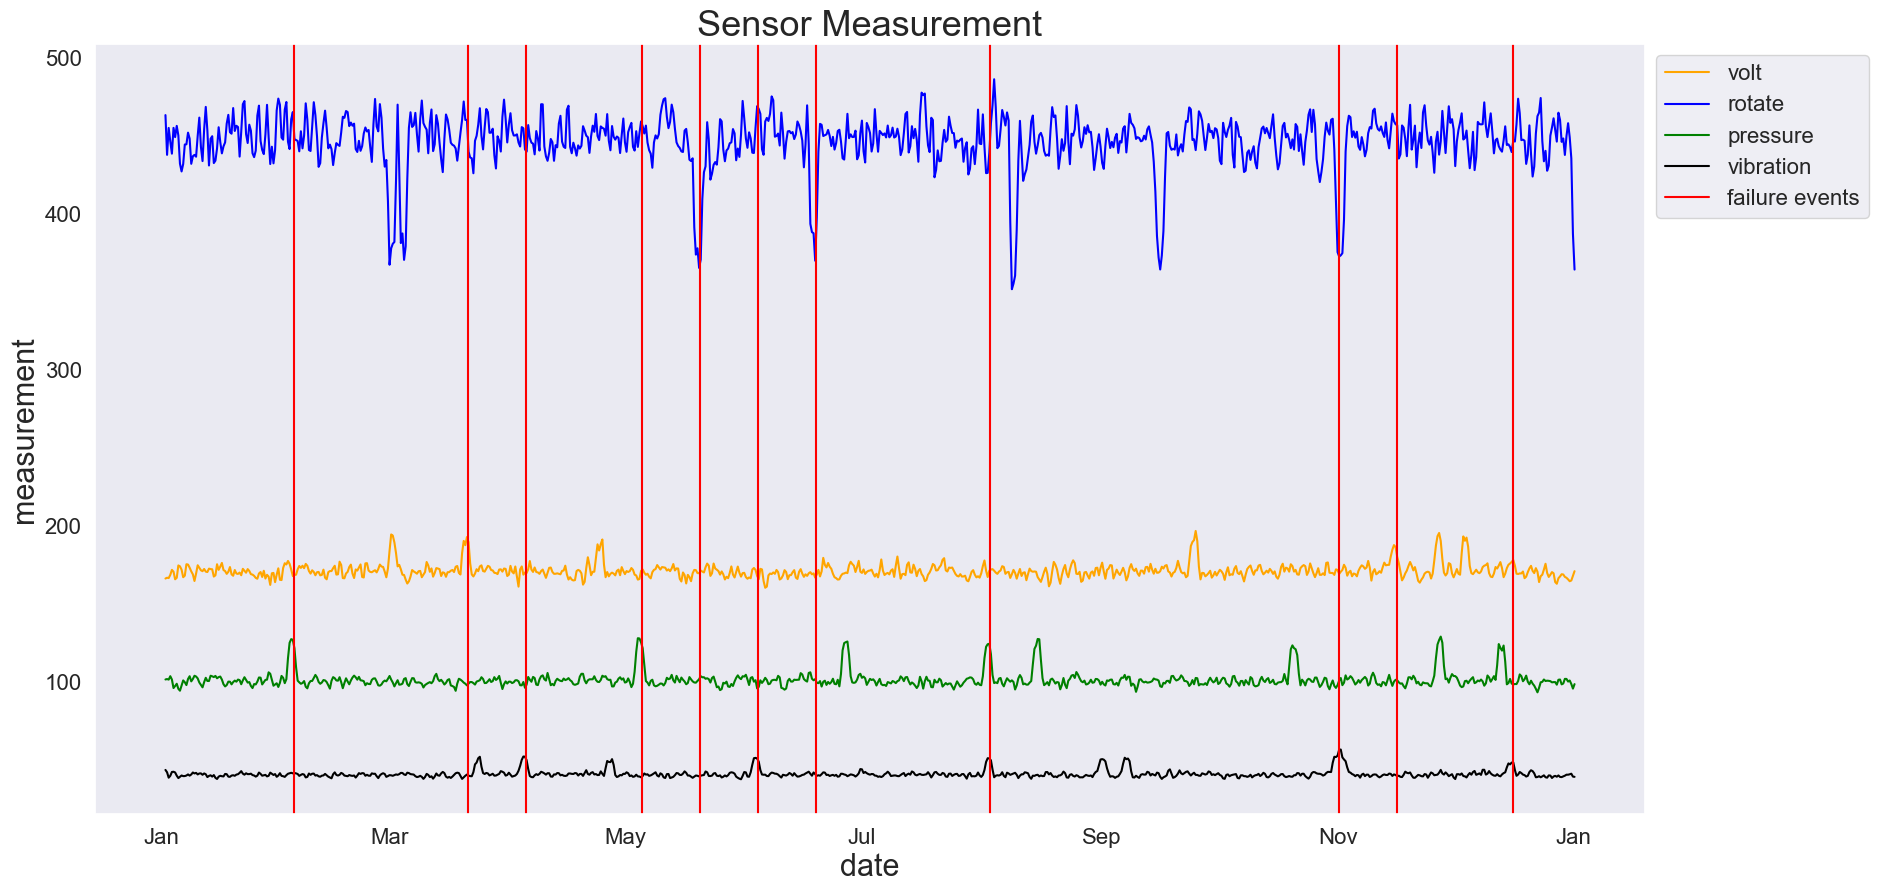

In [253]:
def sliding_mean(data, win_size, step_size=1):
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'):
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
        
    return (pd.DataFrame(data_dict))

slide_mean_data = sliding_mean(sen_data, 20, 10)

plot_diagnostic_data(slide_mean_data, fail_dt, None)

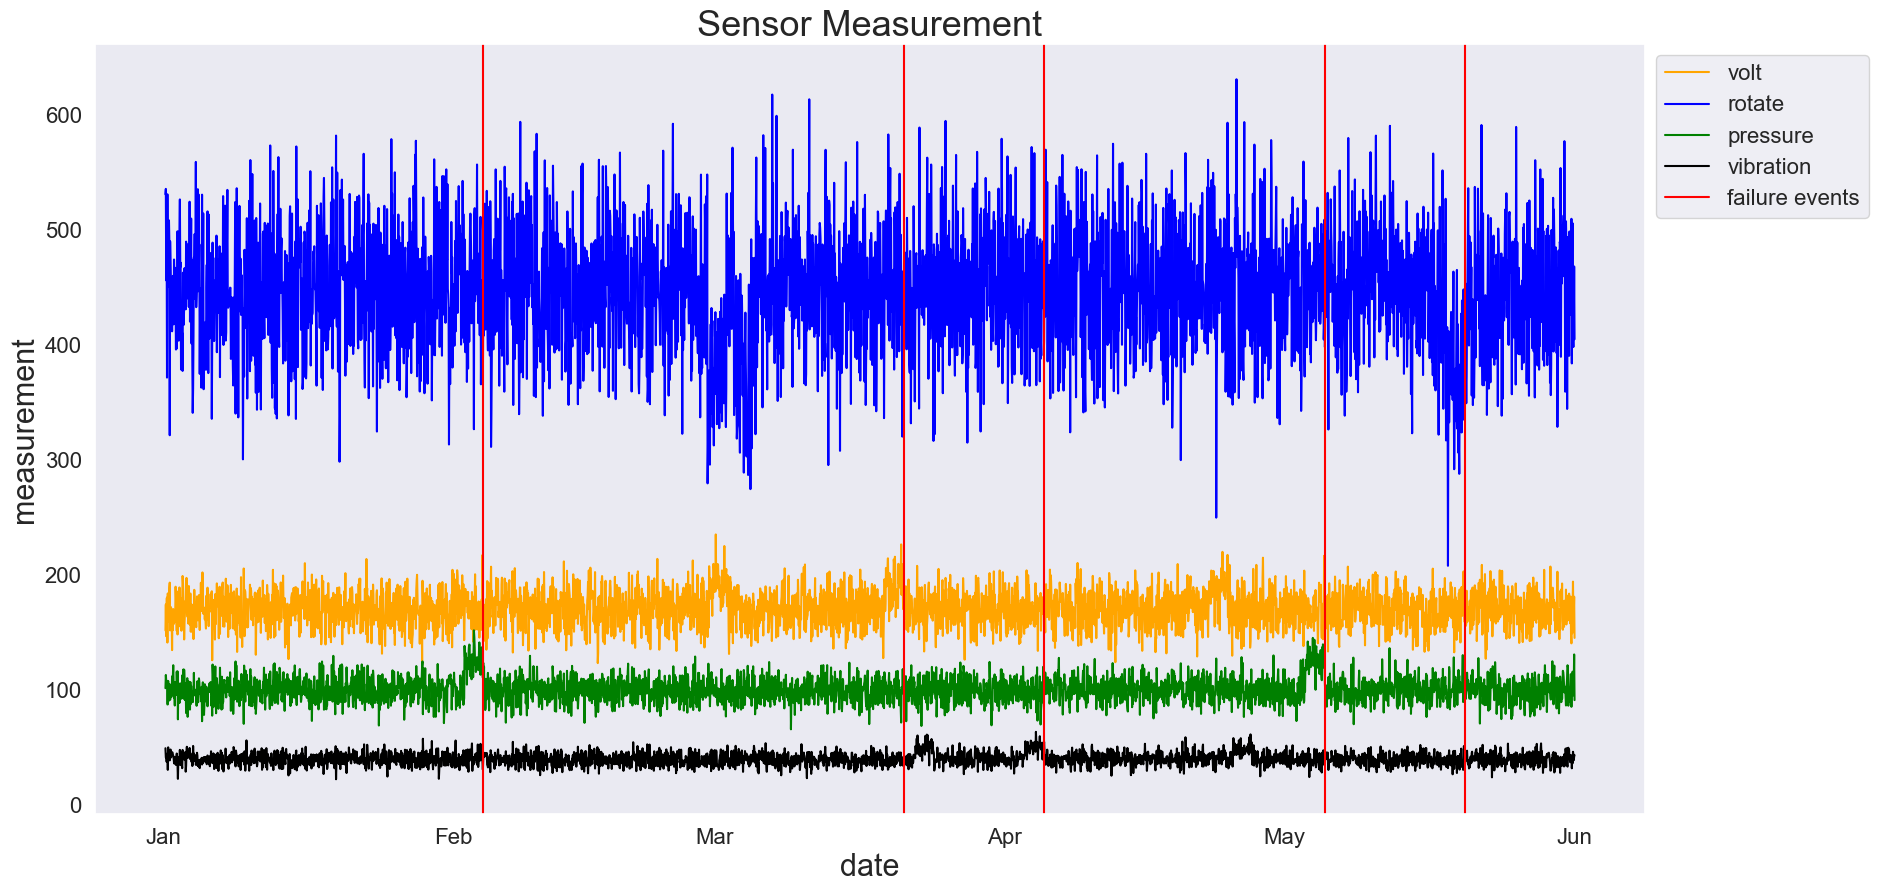

In [254]:
train_tp = pd.to_datetime("2015-06-01")
train_data = sen_data[sen_data['datetime'] <= train_tp]
train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]

plot_diagnostic_data(train_data, train_data_fail, None)


In [255]:
train_data = sliding_mean(train_data, 20, 10)

In [256]:
train_data['state'] = 'normal'
for dt in train_data_fail['datetime']:
    for i in range(len(train_data)):
        # Find time point that was just before failure event
        if(dt < train_data['datetime'][i]):
            train_data.at[i-1, 'state'] = 'failure'
            break
            
train_data['state'].value_counts()

normal     355
failure      5
Name: state, dtype: int64

In [257]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

KNeighborsClassifier(n_neighbors=3)

In [258]:
all_data = sliding_mean(sen_data, 20, 10)
knn_predict = knn_model.predict(all_data[all_data.columns.difference(['datetime', 'state'])])
knn_fail_dt = all_data[knn_predict=='failure']['datetime'].to_frame().reset_index()
knn_fail_dt

,index,datetime
0,78,2015-02-03 13:00:00
1,79,2015-02-03 23:00:00
2,423,2015-06-27 07:00:00
3,792,2015-11-28 01:00:00


In [259]:
true_state = {'datetime' : all_data['datetime'],
              'state' : ['normal']*len(all_data)}
true_state = pd.DataFrame(true_state)
for dt in fail_dt['datetime']:
    for i in range(len(true_state)):
        # Find time point that was just before failure event
        if(dt < true_state['datetime'][i]):
            true_state.at[i-1, 'state'] = 'failure'
            break

true_state = np.array(true_state['state'])

In [260]:
def classification_metrics(predicted, true):    
    cm = confusion_matrix(true, predicted, labels = ['failure', 'normal'])
    print("Confusion Matrix:")
    print("             Predicted")
    print("             failure normal")
    print("True failure       " + str(cm[0][0]) + "      " + str(cm[0][1]))
    print("      normal       " + str(cm[1][0]) + "     " + str(cm[1][1]))

    acc = accuracy_score(true, predicted)*100
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))*100
    print('\nWith accuracy of {0:.2f}% and GMean score of {1:.2f}%'.format(acc, gm))

# Write the code to compute Recall, Specificity, Precision and F-score in the function above
# Print out these results   

In [261]:
knn_predict

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'failure', 'failure', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'no

In [262]:
classification_metrics(knn_predict, true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       3     861

With accuracy of 98.51% and GMean score of 30.10%


Methods 2
PCA

In [263]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [264]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [265]:
X_train = train_data.set_index('datetime')  # Training data set
X_all = all_data.set_index('datetime')  # All the data set

In [266]:
from sklearn.decomposition import PCA # Build the PCA model
PCA = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = PCA.fit_transform(X_train[['volt', 'rotate', 'pressure', 'vibration']])
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_all_PCA = PCA.transform(X_all[['volt', 'rotate', 'pressure', 'vibration']])
X_all_PCA = pd.DataFrame(X_all_PCA)
X_all_PCA.index = X_all.index

In [267]:
#Define PCA for training adn testing dataset
pca_train = np.array(X_train_PCA.values)
pca_test = np.array(X_all_PCA.values)

In [268]:
cov_matrix, inv_cov_matrix  = cov_matrix(X_train[['volt', 'rotate', 'pressure', 'vibration']])

In [269]:
X_train_values = X_train[['volt', 'rotate', 'pressure', 'vibration']]
X_all_values = X_all[['volt', 'rotate', 'pressure', 'vibration']]
mean = X_train[['volt', 'rotate', 'pressure', 'vibration']].mean(axis=0)

In [270]:
#Calculate Mahalanobis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff.iloc[i].dot(inv_covariance_matrix).dot(diff.iloc[i])))
    return md

In [271]:
#Calculate threshold
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [272]:
# Based on training data get threshold
distance_train = MahalanobisDist(inv_cov_matrix, mean, X_train_values, verbose=False)
distance_all = MahalanobisDist(inv_cov_matrix, mean, X_all_values, verbose=False)
threshold = MD_threshold(distance_all, extreme = True)

/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/3309462156.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distance_all,


Text(0.5, 0, 'Mahalanobis distance')

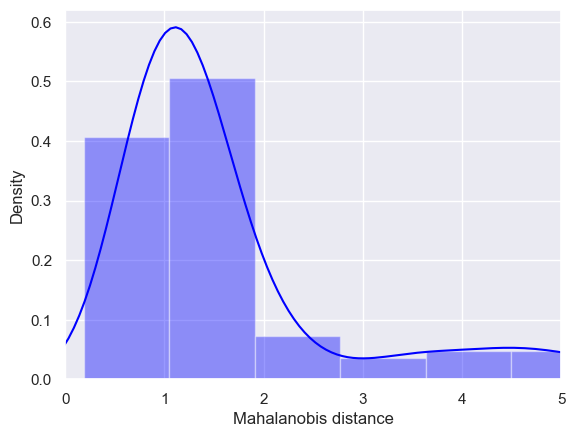

In [273]:
# View the distribution of Mahalanobis distance
plt.figure()
sns.distplot(distance_all,
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis distance')

<function matplotlib.pyplot.show(close=None, block=None)>

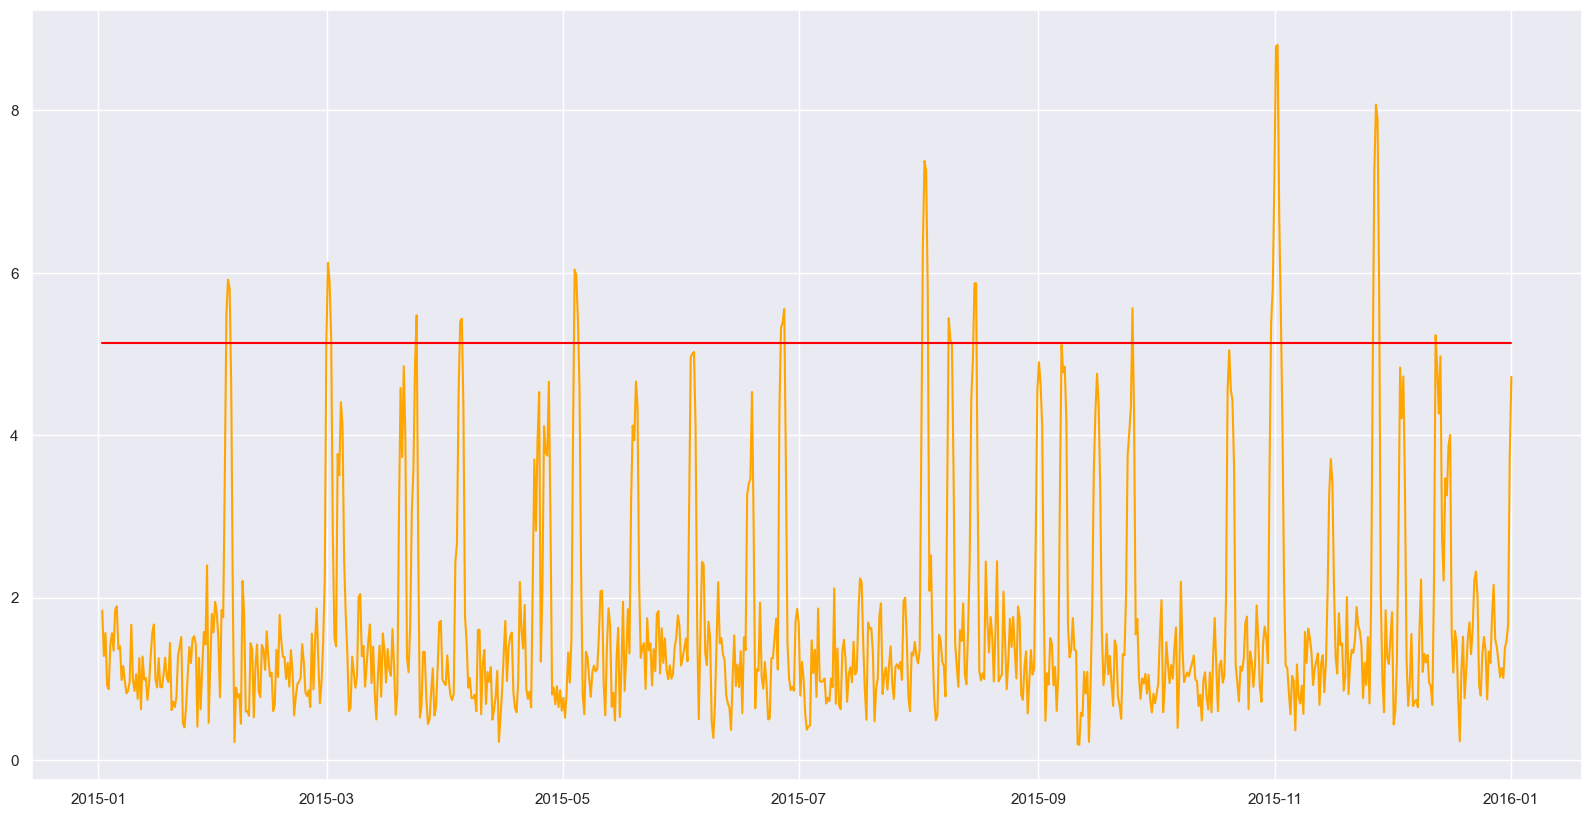

In [274]:
fig, ax =  plt.subplots(figsize=(20,10))
y = threshold*np.ones([len(all_data),1])
ax.plot(all_data['datetime'], distance_all, color='orange', label='volt')
ax.plot(all_data['datetime'], y, color='red', label='rotate')
plt.show

In [275]:
all_data

,datetime,volt,rotate,pressure,vibration
0,2015-01-02 01:00:00,165.986300,463.146618,101.252537,43.257060
1,2015-01-02 11:00:00,166.481762,437.660900,101.532750,41.730663
2,2015-01-02 21:00:00,166.287348,454.921207,101.167522,38.284306
3,2015-01-03 07:00:00,168.322989,446.274223,103.356567,39.485176
4,2015-01-03 17:00:00,171.531552,438.418174,101.218941,41.933467
...,...,...,...,...,...
870,2015-12-30 13:00:00,165.436356,457.938250,99.915585,40.193714
871,2015-12-30 23:00:00,164.249251,448.916162,100.596193,40.461757
872,2015-12-31 09:00:00,164.724396,435.379076,98.342306,40.831574
873,2015-12-31 19:00:00,167.800107,387.045455,95.396207,38.966104


In [276]:
pca_state = pd.DataFrame()
pca_state['datetime'] = all_data['datetime']
pca_state['state'] = 'normal'

In [277]:
pca_state

,datetime,state
0,2015-01-02 01:00:00,normal
1,2015-01-02 11:00:00,normal
2,2015-01-02 21:00:00,normal
3,2015-01-03 07:00:00,normal
4,2015-01-03 17:00:00,normal
...,...,...
870,2015-12-30 13:00:00,normal
871,2015-12-30 23:00:00,normal
872,2015-12-31 09:00:00,normal
873,2015-12-31 19:00:00,normal


In [278]:
distance_all > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [279]:
# Combine the continous error into one error
X_all['Maha_dis']  = distance_all
for i in range(len(distance_all)):
    t = 0
    while  distance_all[i+t] > threshold:
        distance_all[i+t] = threshold
        t += 1
    if t > 0:
        distance_all[i + round(t/2)] = threshold+1
distance_all > threshold


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [280]:
pca_state

,datetime,state
0,2015-01-02 01:00:00,normal
1,2015-01-02 11:00:00,normal
2,2015-01-02 21:00:00,normal
3,2015-01-03 07:00:00,normal
4,2015-01-03 17:00:00,normal
...,...,...
870,2015-12-30 13:00:00,normal
871,2015-12-30 23:00:00,normal
872,2015-12-31 09:00:00,normal
873,2015-12-31 19:00:00,normal


In [282]:
X_all['state'] = 'normal'
fail_pca = pd.DataFrame()
for i in range(len(distance_all)):
    if distance_all[i]<=threshold:
        pca_state['state'].iloc[i] = 'normal'
        #X_all['state'].iloc[i] = 'normal' 
    else:
        pca_state['state'].iloc[i] = 'failure'
        
        #X_all['state'].iloc[i] = 'failure'

fail_pca['datetime'] = pd.to_datetime(pca_state[pca_state['state']=='failure']['datetime'])  #fail_dt[fail_dt['datetime'] <= train_tp]
fail_pca = fail_pca.reset_index(drop=True)

/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/1506974583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_state['state'].iloc[i] = 'normal'
/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/1506974583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_state['state'].iloc[i] = 'failure'


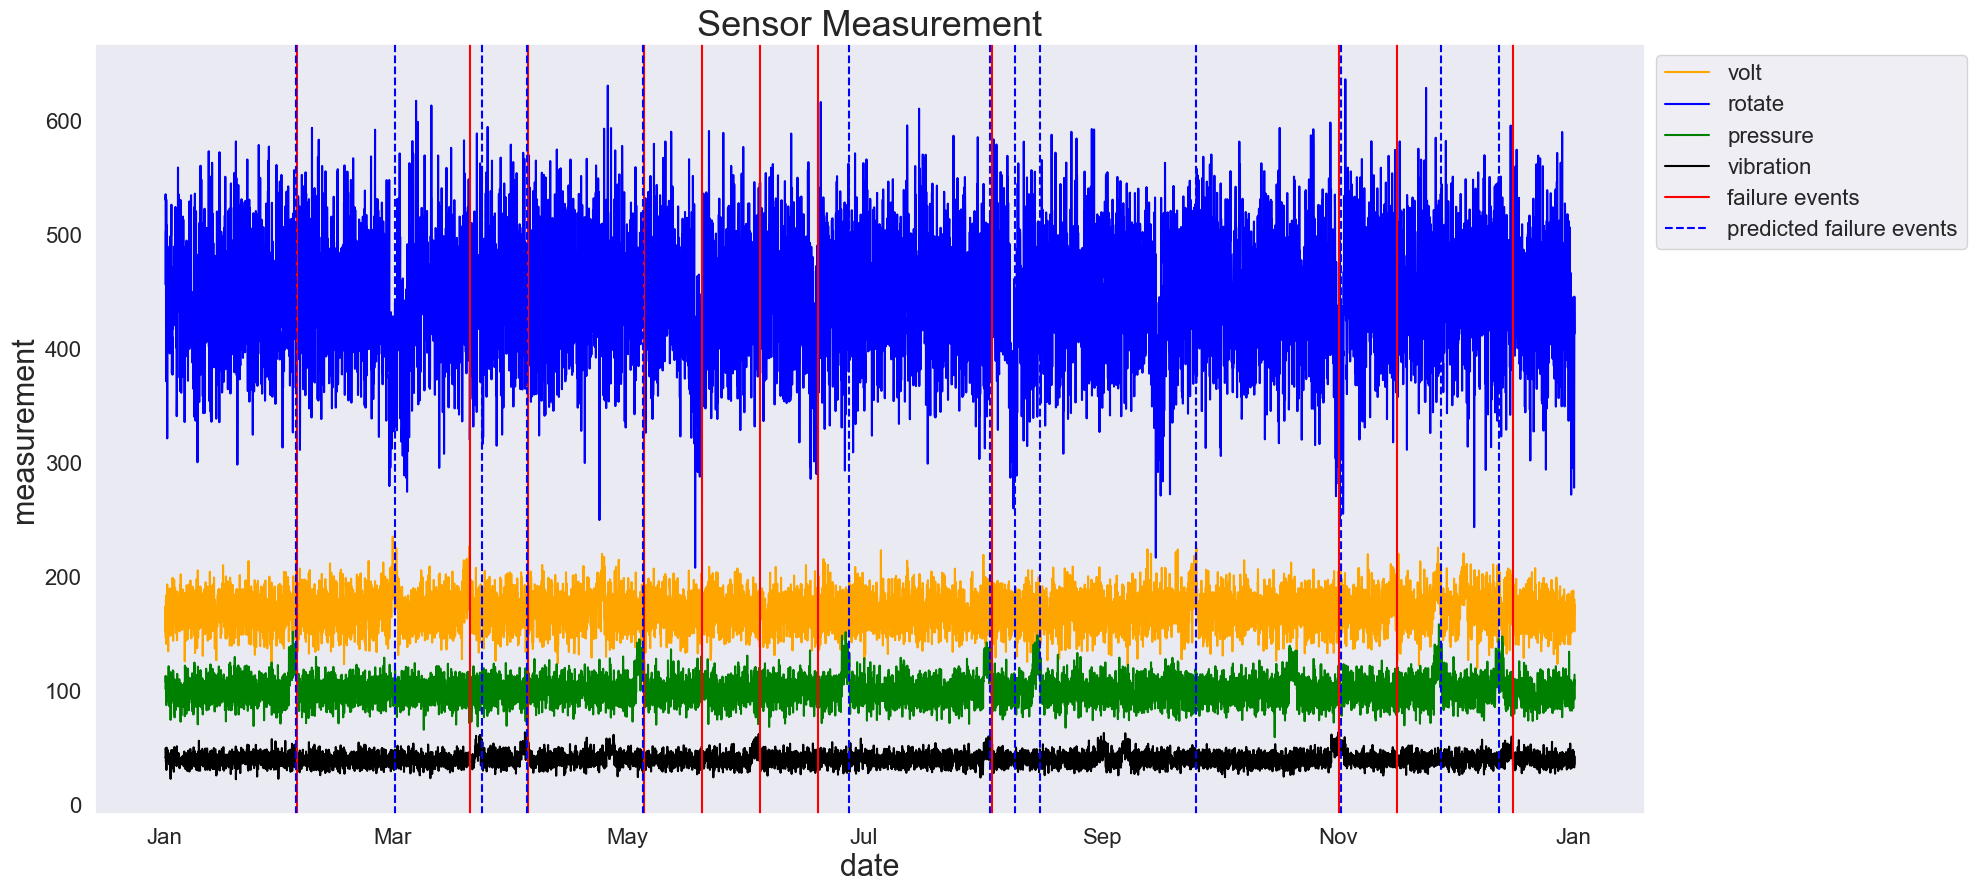

In [283]:
plot_diagnostic_data(sen_data, fail_dt, fail_pca)

In [284]:
pca_state['state'].value_counts()

normal     862
failure     13
Name: state, dtype: int64

In [349]:
pca_state['datetime'] = pd.to_datetime(pca_state['datetime'])
classification_metrics(pca_state['state'], true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       4      7
      normal       9     855

With accuracy of 98.17% and GMean score of 59.99%


PCA
X_train = X_train[['volt', 'rotate', 'pressure', 'vibration']]
X_all = X_all[['volt', 'rotate', 'pressure', 'vibration']]

In [286]:
X_train


,volt,rotate,pressure,vibration,state
datetime,,,,,
2015-01-02 01:00:00,165.986300,463.146618,101.252537,43.257060,normal
2015-01-02 11:00:00,166.481762,437.660900,101.532750,41.730663,normal
2015-01-02 21:00:00,166.287348,454.921207,101.167522,38.284306,normal
2015-01-03 07:00:00,168.322989,446.274223,103.356567,39.485176,normal
2015-01-03 17:00:00,171.531552,438.418174,101.218941,41.933467,normal
...,...,...,...,...,...
2015-05-29 23:00:00,173.652890,441.694405,103.889893,38.212154,normal
2015-05-30 09:00:00,169.655455,436.350620,102.308495,37.640583,normal
2015-05-30 19:00:00,167.203435,450.709471,101.471011,37.278153,normal


In [287]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
X = X_train[['volt', 'rotate', 'pressure', 'vibration']].values

y = X_train["state"].values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y).T
#print(y)

target_names = le.classes_
print(target_names)


['failure' 'normal']


In [288]:
y.shape

(360,)

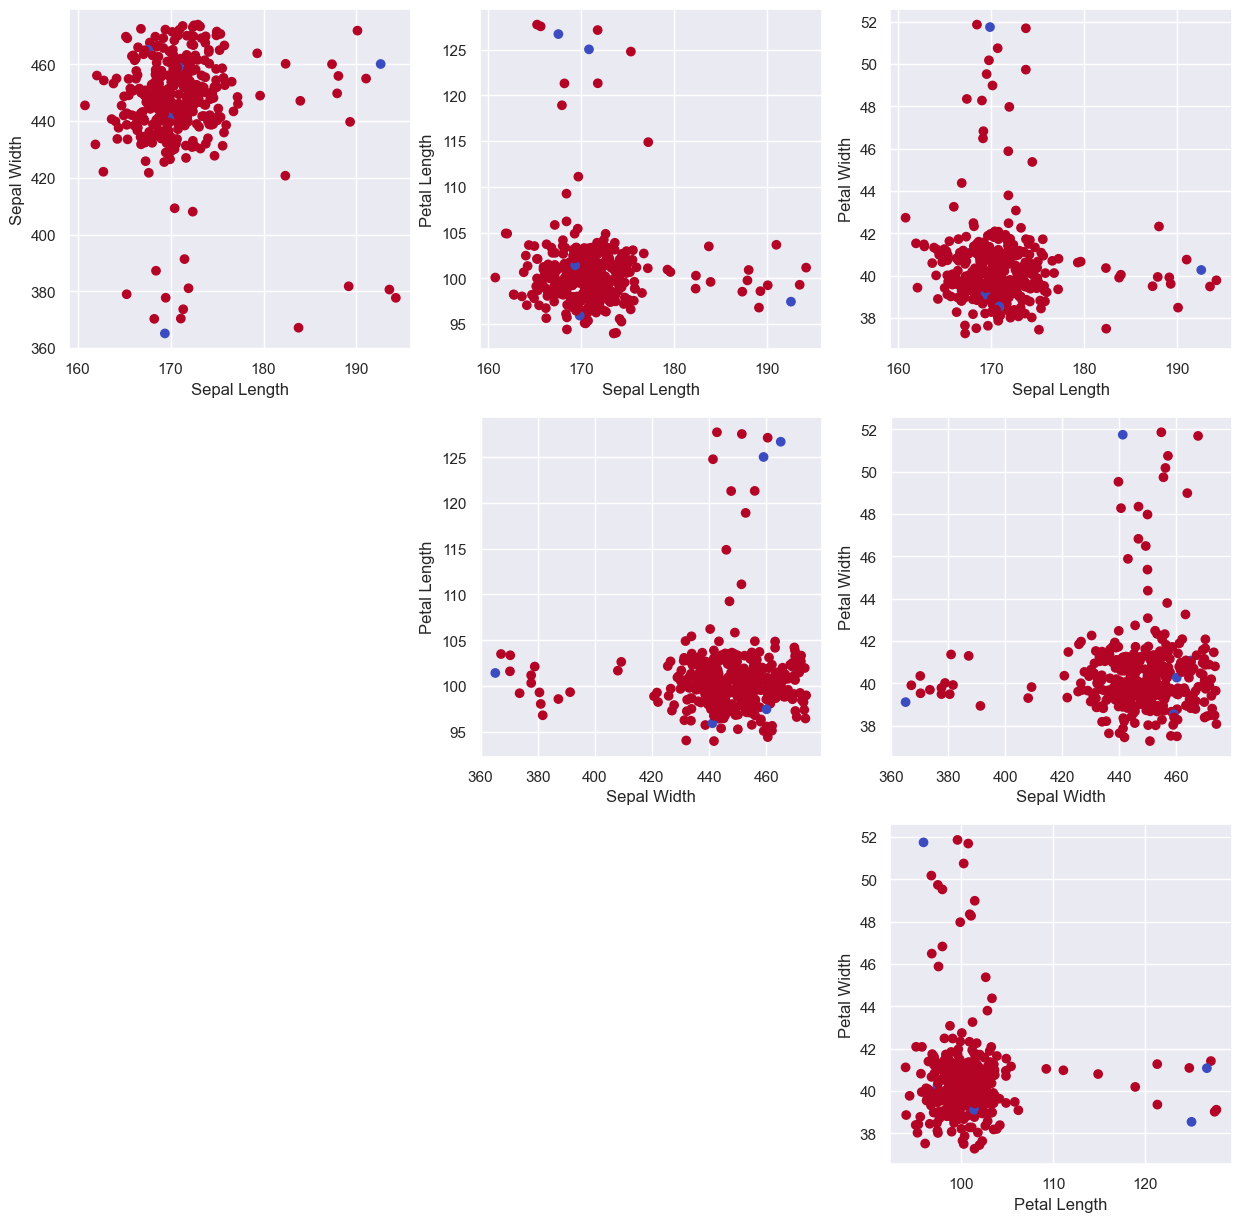

In [289]:
# # View the anomaly distribution between different factors
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.scatter(X_train["volt"], X_train["rotate"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

plt.subplot(332)
plt.scatter(X_train["volt"], X_train["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Length')

plt.subplot(333)
plt.scatter(X_train["volt"], X_train["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')

plt.subplot(335)
plt.scatter(X_train["rotate"], X_train["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Width'); plt.ylabel('Petal Length')

plt.subplot(336)
plt.scatter(X_train["rotate"], X_train["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Width'); plt.ylabel('Petal Width')

plt.subplot(339)
plt.scatter(X_train["pressure"], X_train["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Petal Length'); plt.ylabel('Petal Width')


plt.show()

In [290]:
pca_state['state']

0      normal
1      normal
2      normal
3      normal
4      normal
        ...  
870    normal
871    normal
872    normal
873    normal
874    normal
Name: state, Length: 875, dtype: object

In [291]:
X_train['Maha_dis'] = distance_train

X_all['Maha_dis']  = distance_all

In [292]:
pca_state['state']

0      normal
1      normal
2      normal
3      normal
4      normal
        ...  
870    normal
871    normal
872    normal
873    normal
874    normal
Name: state, Length: 875, dtype: object

Text(0, 0.5, 'Petal Width')

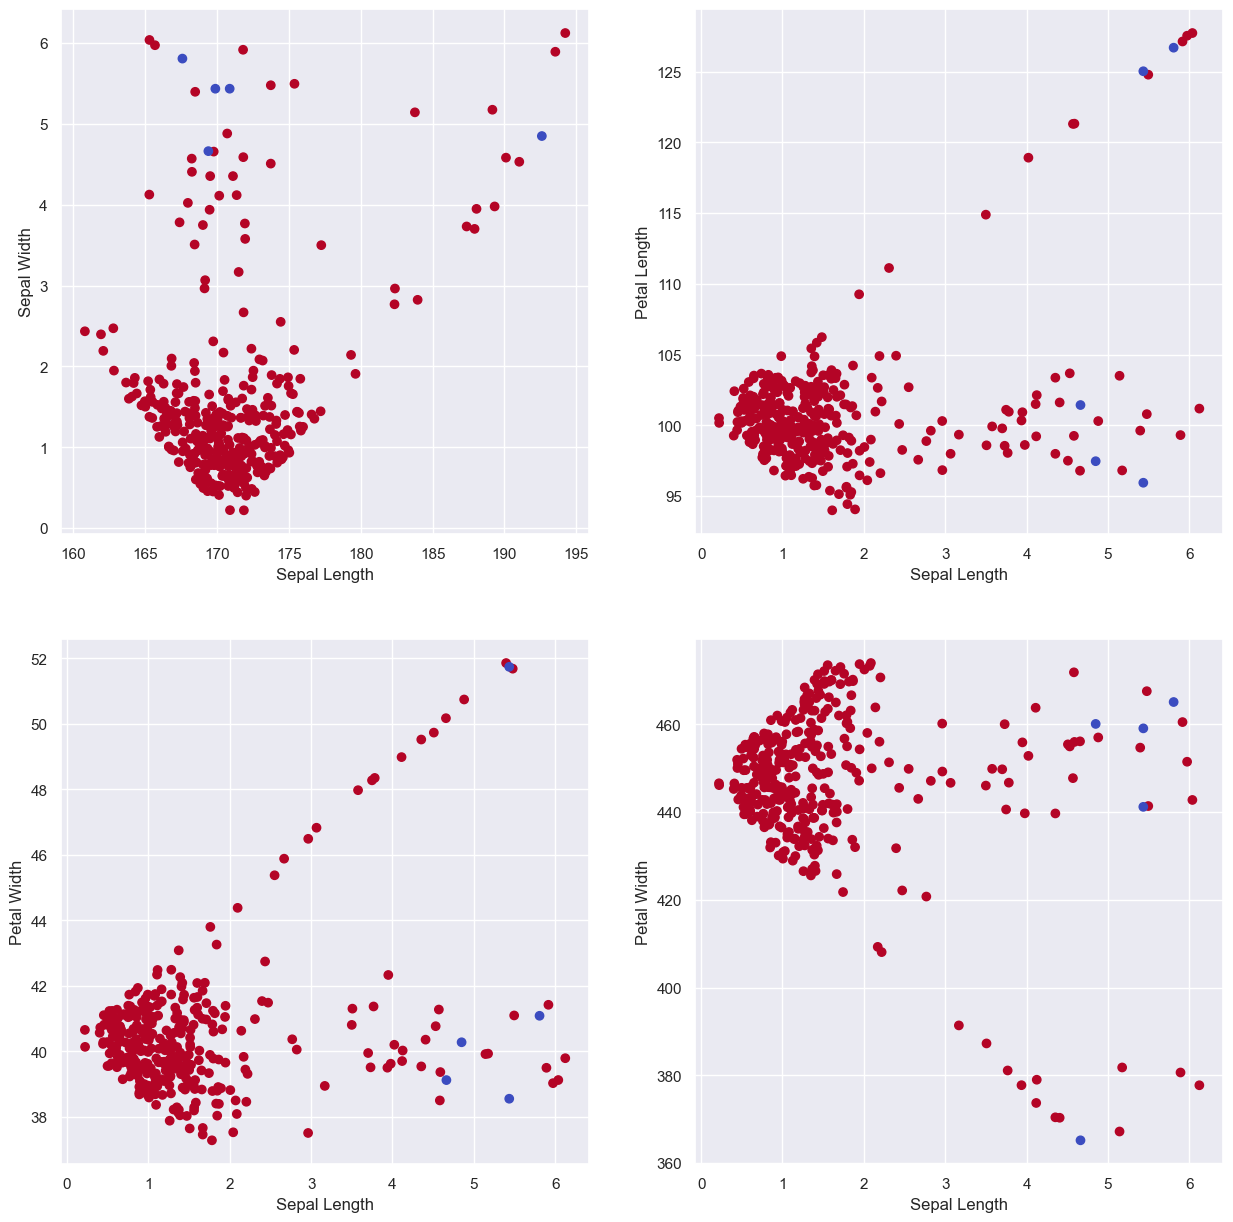

In [293]:
# View the anomaly distribution between different factors with "Maha_dis"
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.scatter(X_train["volt"], X_train["Maha_dis"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

plt.subplot(222)
plt.scatter(X_train["Maha_dis"], X_train["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Length')

plt.subplot(223)
plt.scatter(X_train["Maha_dis"], X_train["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')

plt.subplot(224)
plt.scatter(X_train["Maha_dis"], X_train["rotate"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')


In [294]:
Y_train_predict = pd.DataFrame()
Y_train_predict['state'] = X_train['state']
Y_train_predict = Y_train_predict.reset_index()
Y_train_predict

,datetime,state
0,2015-01-02 01:00:00,normal
1,2015-01-02 11:00:00,normal
2,2015-01-02 21:00:00,normal
3,2015-01-03 07:00:00,normal
4,2015-01-03 17:00:00,normal
...,...,...
355,2015-05-29 23:00:00,normal
356,2015-05-30 09:00:00,normal
357,2015-05-30 19:00:00,normal
358,2015-05-31 05:00:00,normal


In [295]:
X = X_train[['volt', 'rotate', 'pressure', 'vibration','Maha_dis']].values

Y = X_train["state"].values
le = preprocessing.LabelEncoder()
le.fit(y)
Y = le.transform(y).T
#print(y)

target_names = le.classes_
print(target_names)

[0 1]


In [333]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print("Principal Component Analysis: ")
print("Explained variance ratio (first two components): " + str(pca.explained_variance_ratio_))
print("These two components cover " + str(round(100*sum(pca.explained_variance_ratio_) ,2)) + "% of the variance")

Principal Component Analysis: 
Explained variance ratio (first two components): [0.86927094 0.06108284]
These two components cover 93.04% of the variance


/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/1576958799.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_predict['state'].iloc[i] = 'normal'
/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/1576958799.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_predict['state'].iloc[i] = 'fail'


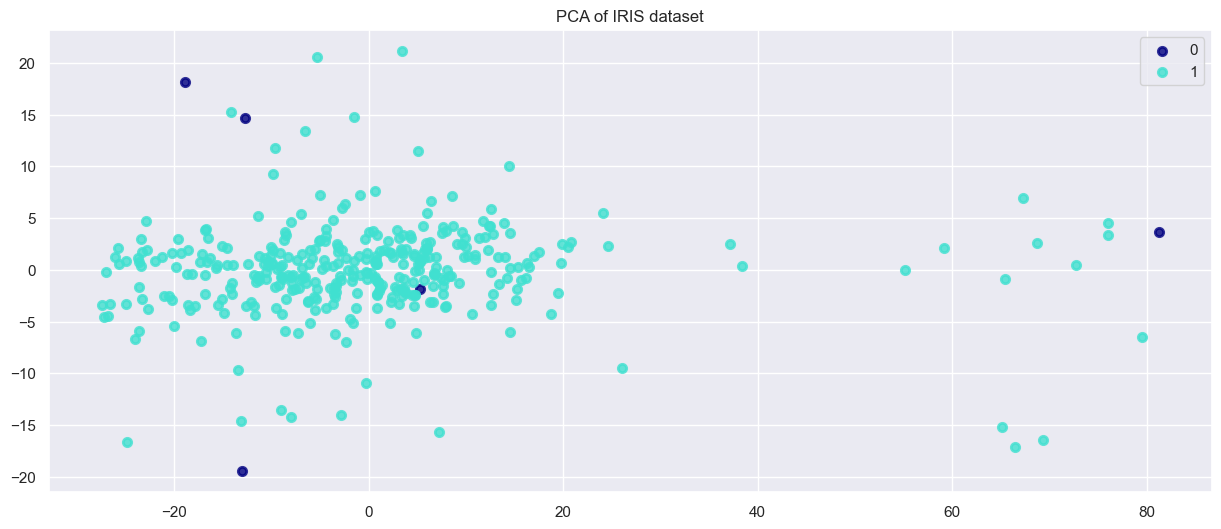

In [334]:
plt.figure(figsize=(15,6))

colors = ['navy', 'turquoise']
lw = 2

#plt.subplot(121)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[Y  == i, 0], X_r[Y  == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

for  i in range(len(Y)):
    if Y[i] == 1:
        Y_train_predict['state'].iloc[i] = 'normal'
    else:
        Y_train_predict['state'].iloc[i] = 'fail'
#plt.subplot(122)
#for color, i, target_name in zip(colors, [0, 1], target_names):
#    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
#                label=target_name)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA of IRIS dataset')

#plt.show()

In [338]:
XX = X_all[['volt', 'rotate', 'pressure', 'vibration','Maha_dis']].values
yy = true_state
res_all = pca.fit(XX).transform(XX)

In [339]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(res_all)
y_kmeans = kmeans.predict(res_all)

In [ ]:
centers, labels = find_clusters(res_all,2)

plt.scatter(res_all[:,0], res_all[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [343]:
# Combine the continous error into one error

for i in range(len(y_kmeans)):
    t = 0
    while  y_kmeans[i+t] == 0:
        y_kmeans[i+t] = 1
        t += 1
    if t > 0:
        y_kmeans[i + round(t/2)] = 0
y_kmeans


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [332]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly Choose Clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a assign labels  based on closest center
        labels = pairwise_distances_argmin(X,centers)
        
        # 2b find new centers from mean of the points
        new_centers = np.array([X[labels == i].mean(0) for i in range (n_clusters)])
        
        # 2c Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

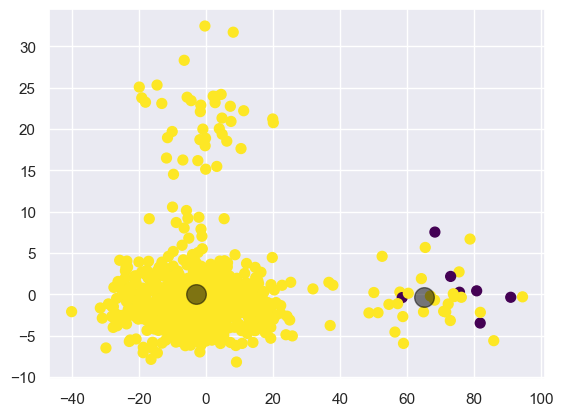

In [344]:
centers, labels = find_clusters(res_all,2)

plt.scatter(res_all[:,0], res_all[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [345]:
fail_Km = pd.DataFrame()
fail_Km['datetime'] = pd.to_datetime(pca_state[y_kmeans == 0]['datetime'])  #fail_dt[fail_dt['datetime'] <= train_tp]
fail_Km = fail_Km.reset_index(drop=True)

In [348]:
fail_Km

,datetime
0,2015-03-01 09:00:00
1,2015-03-04 17:00:00
2,2015-05-19 23:00:00
3,2015-06-18 13:00:00
4,2015-08-09 05:00:00
5,2015-09-16 03:00:00
6,2015-11-01 19:00:00


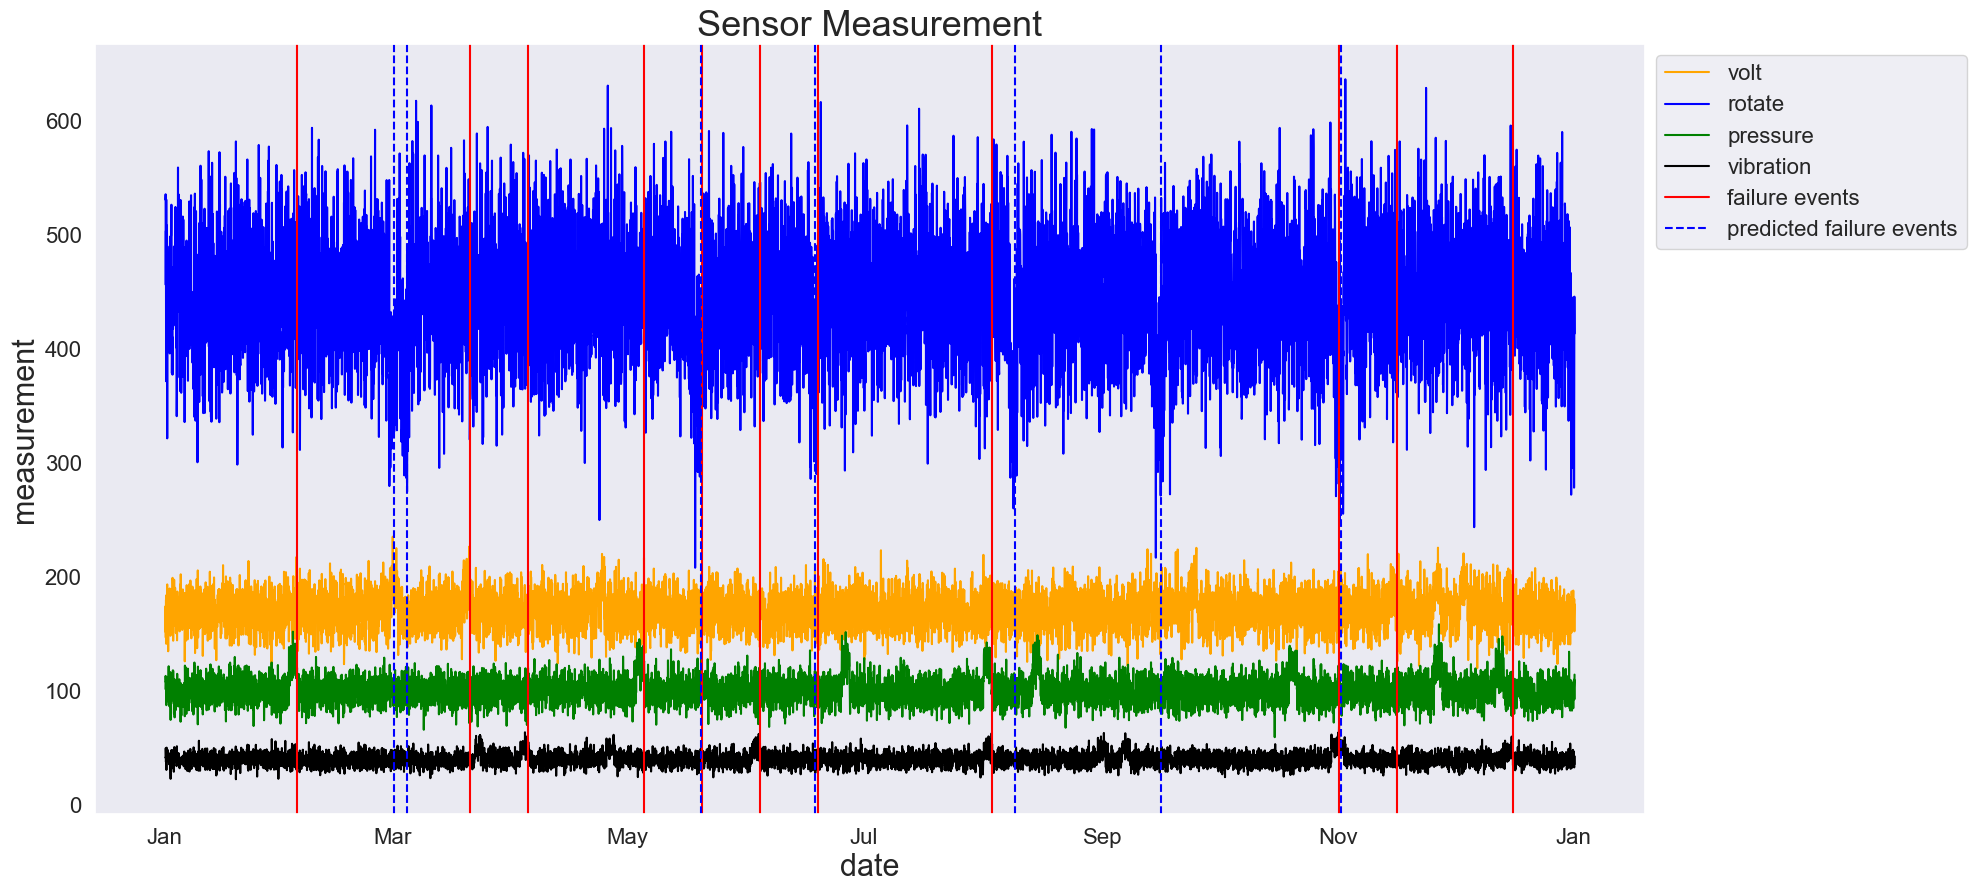

In [347]:
plot_diagnostic_data(sen_data, fail_dt, fail_Km) 

In [361]:
all_data.shape

(875, 5)

In [365]:
(true_state)

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'failure', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'nor

In [370]:
y_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [375]:
Km_state = pd.DataFrame()
Km_state['datetime'] = all_data['datetime']
Km_state['state'] = 'normal'
for i in range(len(y_kmeans)):
    if y_kmeans[i] == 0:
        Km_state['state'].iloc[i] = 'failure'



/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_1090/2815094720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Km_state['state'].iloc[i] = 'failure'


875

In [376]:
classification_metrics(Km_state['state'], true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       6     858

With accuracy of 98.17% and GMean score of 30.05%


测试所有数据